# The Plug-and-Chug Notebook for Getting Your Keypoint Moseq syllable-at-a-frame CSV file and Visualizations:
## This notebook includes:
   ### **1. Re-encoding videos**
   ### **2. Creating inferences (label) on your videos using an existing SLEAP model and exporting the coordinates in an .h5 file**
   - you can also do the inferences and exporting the coordinates in the SLEAP application. When running the inferences in the SLEAP app, depending on if and what error message you get, you may need to **re-encode your videos** 
   ### **3. Getting Behavioral Syllables**
   before this step you will have to go to [kpmsmodelmakingtutorial.ipynb](tutorial-notebooks/kpmsmodelmakingtutorial.ipynb) if you do not already have a Keypoint Model trained and the `checkpoint.h5` from that training
   - ##### a. Getting ```results.h5``` from your ```checkpoint.h5```
   - ##### b. Trajectory plots, grid movies, and other visualizations of your behavioral syllables
   - ##### c. ```.csv``` files for analysis



This notebook does not include:
   - how to create and train a SLEAP model
   - how to create and train a Keypoint Moseq model



First, let's get your packages imported so we can use them in our code. A list of packages that you need to install in your environment is in the README.md file. Remember **importing =/= installing** (I've made this silly mistake multiple times when sleep deprived)

In [1]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages


##### Set up filepaths

In [4]:
beforereencodingvidfolder_dir = r'Y:\Karin\tutorialmaking\morekatiesvideosmodeling\beforevid' #CHANGE HERE to put videos needed to reencode put None if you don't want to reencode
project_dir = r'Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/' #CHANGE HERE
sleap_model_path = r'Y:\Karin\tutorialmaking\morekatiesvideosmodeling\sleapstuff\240709_092906.multi_instance.n=1301' #CHANGE HERE where is your SLEAP model?
kpmsmodel_name = '2024_07_25-09_09_03arhmm1e4' #CHANGE HERE what is the name of your keypoint moseq model? (not the file path)

##### Just setting this up here, but in order for this next cell to work, you need to put your videos (if they are already reencoded or do not need to be reencoded) **in a folder called `videos` within your project directory**
- your `.h5` labels from SLEAP will end up in the `videos` folder. 
- this cell sets the directory of `videos` in your `project_dir` and creates a folder called `videos` if it does not exist.
- if your videos need to be reencoded, just put them in a different folder within your `project_dir` and set your `beforereencodingvidfolder_dir` to that folderpath

In [4]:
video_dir = os.path.join(project_dir, 'videos')
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

# 1. Re-encoding videos
A common problem with SLEAP are videos that are [not reliably seekable](https://sleap.ai/develop/help.html). In my experience, sometimes when I want to run inferences, SLEAP will print out an error in the error log saying something about an issue with the last frame of the video. I've had this issue with a few videos on the Grid (but somehow not Katie's) and it has to do with how the video data is stored (I'm pretty sure). I have also had issues using Keypoint Moseq where it tells me there is some trouble with a given frame in a video. One of the things you can to trouble shoot is re-encoding. Something to note is that re-encoding ***changes your file***, and 

Anyways, here is a function that will reencode your videos in the ```beforereencodingvidfolder_dir``` folder directory and put them in your `video_dir`


In [5]:
def reencode_videos(beforereencodingvidfolder_dir, video_dir):
    if beforereencodingvidfolder_dir is None or not os.path.exists(beforereencodingvidfolder_dir):
        print('no reencoding today!')
        return
    else:
        # Ensure output directory exists
        os.makedirs(video_dir, exist_ok=True)

        # FFmpeg command template
        ffmpeg_command = 'ffmpeg -y -i "{input_file}" -c:v libx264 -pix_fmt yuv420p -preset superfast -crf 23 "{output_file}"'

        # Iterate through each file in beforevidfolder_dir
        for filename in os.listdir(beforereencodingvidfolder_dir):
            if filename.endswith('.mp4'):
                input_file = os.path.join(beforereencodingvidfolder_dir, filename)
                output_file = os.path.join(video_dir, filename)
                
                # Construct and execute FFmpeg command
                command = ffmpeg_command.format(input_file=input_file, output_file=output_file)
                
                try:
                    subprocess.run(command, shell=True, check=True)
                    print(f'Reencoded {filename} and saved as {os.path.basename(output_file)}')
                except subprocess.CalledProcessError as e:
                    print(f'Error reencoding {filename}: {e}')

Here is the code to execute said function

In [7]:
reencode_videos(beforereencodingvidfolder_dir, video_dir)


Reencoded dL29_P0_pupretrieval_20240104_05.avi.mp4 and saved as dL29_P0_pupretrieval_20240104_05.avi.mp4
Reencoded dL29_P1_pupretrieval_20240204_01.avi.mp4 and saved as dL29_P1_pupretrieval_20240204_01.avi.mp4
Reencoded dL29_P2_pupretrieval_20240304_06.avi.mp4 and saved as dL29_P2_pupretrieval_20240304_06.avi.mp4
Reencoded dL29_P2_pupretrieval_20240304_08.avi.mp4 and saved as dL29_P2_pupretrieval_20240304_08.avi.mp4
Reencoded dL29_P3_pupretrieval_20240404_01.avi.mp4 and saved as dL29_P3_pupretrieval_20240404_01.avi.mp4
Reencoded dL29_P4_pupretrieval_20240504_08.avi.mp4 and saved as dL29_P4_pupretrieval_20240504_08.avi.mp4
Reencoded dL29_P4_pupretrieval_20240504_10.avi.mp4 and saved as dL29_P4_pupretrieval_20240504_10.avi.mp4
Reencoded dL32_P0_pupretrieval_20240804_02.avi.mp4 and saved as dL32_P0_pupretrieval_20240804_02.avi.mp4
Reencoded dL32_P0_pupretrieval_20240804_04.avi.mp4 and saved as dL32_P0_pupretrieval_20240804_04.avi.mp4
Reencoded dL32_P0_pupretrieval_20240804_10.avi.mp4 and 

# 2. Creating inferences (A.K.A. labeling) on your videos using an existing SLEAP model and exporting the 2D coordinates in an .h5 file
At this point you are going to have to change the kernel to "sleap" (whomp whomp) because for some reason I can't do it for you. Believe me, I tried for like an hour. Basically, I couldn't install Keypoint Moseq in the same environment as SLEAP which is why you need to change kernels.

*Anyways*... I wrote a few lines that will run in the terminal to basically generate labels in an .slp file (SLEAP file) and an .h5 file based off of the model that you set 'sleap_model_path' to earlier. The .h5 file is what you will use for classifying the behaviors in your videos. 

You change kernels by clicking "select kernel" in the top right corner 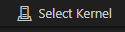 and you will get a drop down menu on the top-middle part of the ribbon. Select the one named "sleap" (or the one with the sleap library in it).
##### TLDR: If you started running this notebook in a different kernel, now is the time to ***change your kernel to sleap***. Also, since changing kernels will reset your variables, ***re-run the cell where you imported your packages and the cell where you specified your file/folder paths***



So this first cell is for SLEAP labeling your videos and producing a .slp file for every video to be labeled (yes it will take awhile)

This will create a folder named `slp_files` within your project directory

In [6]:
slp_output_dir = os.path.join(project_dir, 'slp_files')

In [3]:
# Create 'slp files' directory if it does not exist
if not os.path.exists(slp_output_dir):
    os.makedirs(slp_output_dir)

max_tracks = 1 #number of animals you are tracking
tracker = 'simplemaxtracks'
for filename in os.listdir(video_dir):
    if filename.endswith('.mp4'):
        input_file = os.path.join(video_dir, filename)
        output_filename = os.path.splitext(filename)[0] + '.slp'
        output_file_path = os.path.join(slp_output_dir, output_filename)
        sleap_track_command = f"sleap-track -m {sleap_model_path} " \
                              f"--tracking.tracker {tracker} " \
                              f"--tracking.max_tracking {1} " \
                              f"--tracking.max_tracks {max_tracks} " \
                              f"-o {output_file_path} " \
                              f"{input_file}"
        try:
                # Execute the command
                subprocess.run(sleap_track_command, shell=True, check=True)
                print(f'labeled {filename} and saved as {output_filename}')
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')


labeled dL29_P0_pupretrieval_20240104_05.avi.mp4 and saved as dL29_P0_pupretrieval_20240104_05.avi.mp4


: 

: 

This next cell will convert the .slp files to .h5 files

In [7]:
for filename in os.listdir(slp_output_dir):
    if filename.endswith('.slp'):
        input_slpfile = os.path.join(slp_output_dir, filename)
        output_h5filename = os.path.splitext(filename)[0] + '.h5'
        output_h5file_path = os.path.join(video_dir, output_h5filename)
        sleap_convert_command = f"sleap-convert --format analysis -o {output_h5file_path} {input_slpfile}"
        try:
            subprocess.run(sleap_convert_command)
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')

# 3. Getting Behavioral Syllables
This...figuring out this section was the bane of my existence.


You have to change your kernel again (whomp whomp) to the one with the keypoint moseq library installed

In [6]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages
import keypoint_moseq as kpms

c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\analysis.py:20: UserWarning:

Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.



This will just list all of the .h5 files in your `project_dir/videos/` folder
- in the online [Keypoint Moseq Colab notebook](https://colab.research.google.com/github/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb) from the developers, they have the `videos` folder also have the .h5 labels as well so that is what I am doing here. 

In [4]:
for filename in os.listdir(video_dir):
    if filename.endswith('.h5'):
        print(filename)

dL29_P0_pupretrieval_20240104_05.avi.h5
dL29_P1_pupretrieval_20240204_01.avi.h5
dL29_P2_pupretrieval_20240304_06.avi.h5
dL29_P2_pupretrieval_20240304_08.avi.h5
dL29_P3_pupretrieval_20240404_01.avi.h5
dL29_P4_pupretrieval_20240504_08.avi.h5
dL29_P4_pupretrieval_20240504_10.avi.h5
dL31_P0_pupretrieval_20240104_08.avi.h5
dL32_P0_pupretrieval_20240804_02.avi.h5
dL32_P0_pupretrieval_20240804_04.avi.h5
dL32_P0_pupretrieval_20240804_10.avi.h5
dL32_reintroduction_D1_20242904_02.avi.h5
dL35_P1_pupretrieval_20243004_05.avi.h5
dL35_P2_pupretrieval_20240105_03.avi.h5
dL35_P3_pupretrieval_20240205_01.avi.h5
dL35_P3_pupretrieval_20240205_04.avi.h5
dL36_P0_pupretrieval_20240804_04.avi.h5
dL36_P1_pupretrieval_20240904_02.avi.h5
dL36_P2_pupretrieval_20241004_06.avi.h5
dL36_P2_pupretrieval_20241004_07.avi.h5
dL36_reintroduction_D1_20242904_05.avi.h5
dL37_D6_pupretrieval_20240605_01.avi.h5
dL39_D6_pupretrieval_20240605_01.avi.h5
dL39_D7_pupretrieval_20240705_01.avi.h5
dL39_P0_pupretrieval_20242904_01.avi

### 3a. Getting results.h5 from your checkpoint.h5
So you do need to save your most recent checkpoint as results.h5, do not run this cell a bunch of times it could break things and make things annoying. This code block will also reindex your syllables.

In [4]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, kpmsmodel_name)


# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, kpmsmodel_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, kpmsmodel_name)

Reindexing: 100%|███████████| 23/23 [03:27<00:00,  9.03s/model snapshot]


Saved results to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keyp
ointmoseqwork/2024_07_27-13_41_35arhmm1e3\results.h5


##### Also load your keypoints from your .h5 files
Just so they can be used in your visualizations

In [5]:
# Ensure 'videos' directory within data_dir
keypoint_data_path = os.path.join(project_dir, 'videos')

# Load only files ending with .h5
h5_files = [f for f in os.listdir(keypoint_data_path) if f.endswith('.h5')]

# Assuming kpms.load_keypoints and kpms.format_data are functions provided by a library
coordinates, confidences, bodyparts = kpms.load_keypoints([os.path.join(keypoint_data_path, f) for f in h5_files], 'sleap')


Loading keypoints: 100%|████████████████| 46/46 [00:11<00:00,  4.09it/s]
c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\util.py:836: UserWarning:


Coordinates for the following bodyparts are missing (set to NaN) in at least 50.0% of frames:
 - tailEnd



c:\Users\Steve\anaconda3\envs\keypoint_moseq\lib\site-packages\keypoint_moseq\util.py:842: UserWarning:

This may cause problems during modeling. See https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#high-proportion-of-nans for additional information.



### 3b. Trajectory plots, grid movies, and other visualizations of your behavioral syllables


In [6]:
results = kpms.load_results(project_dir, kpmsmodel_name)
config = lambda: kpms.load_config(project_dir)

##### Make Trajectory Plots:

Saving trajectory plots to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_27-13_41_35arhmm1e3\trajectory_plots


Generating trajectory plots: 100%|██████| 20/20 [00:28<00:00,  1.45s/it]


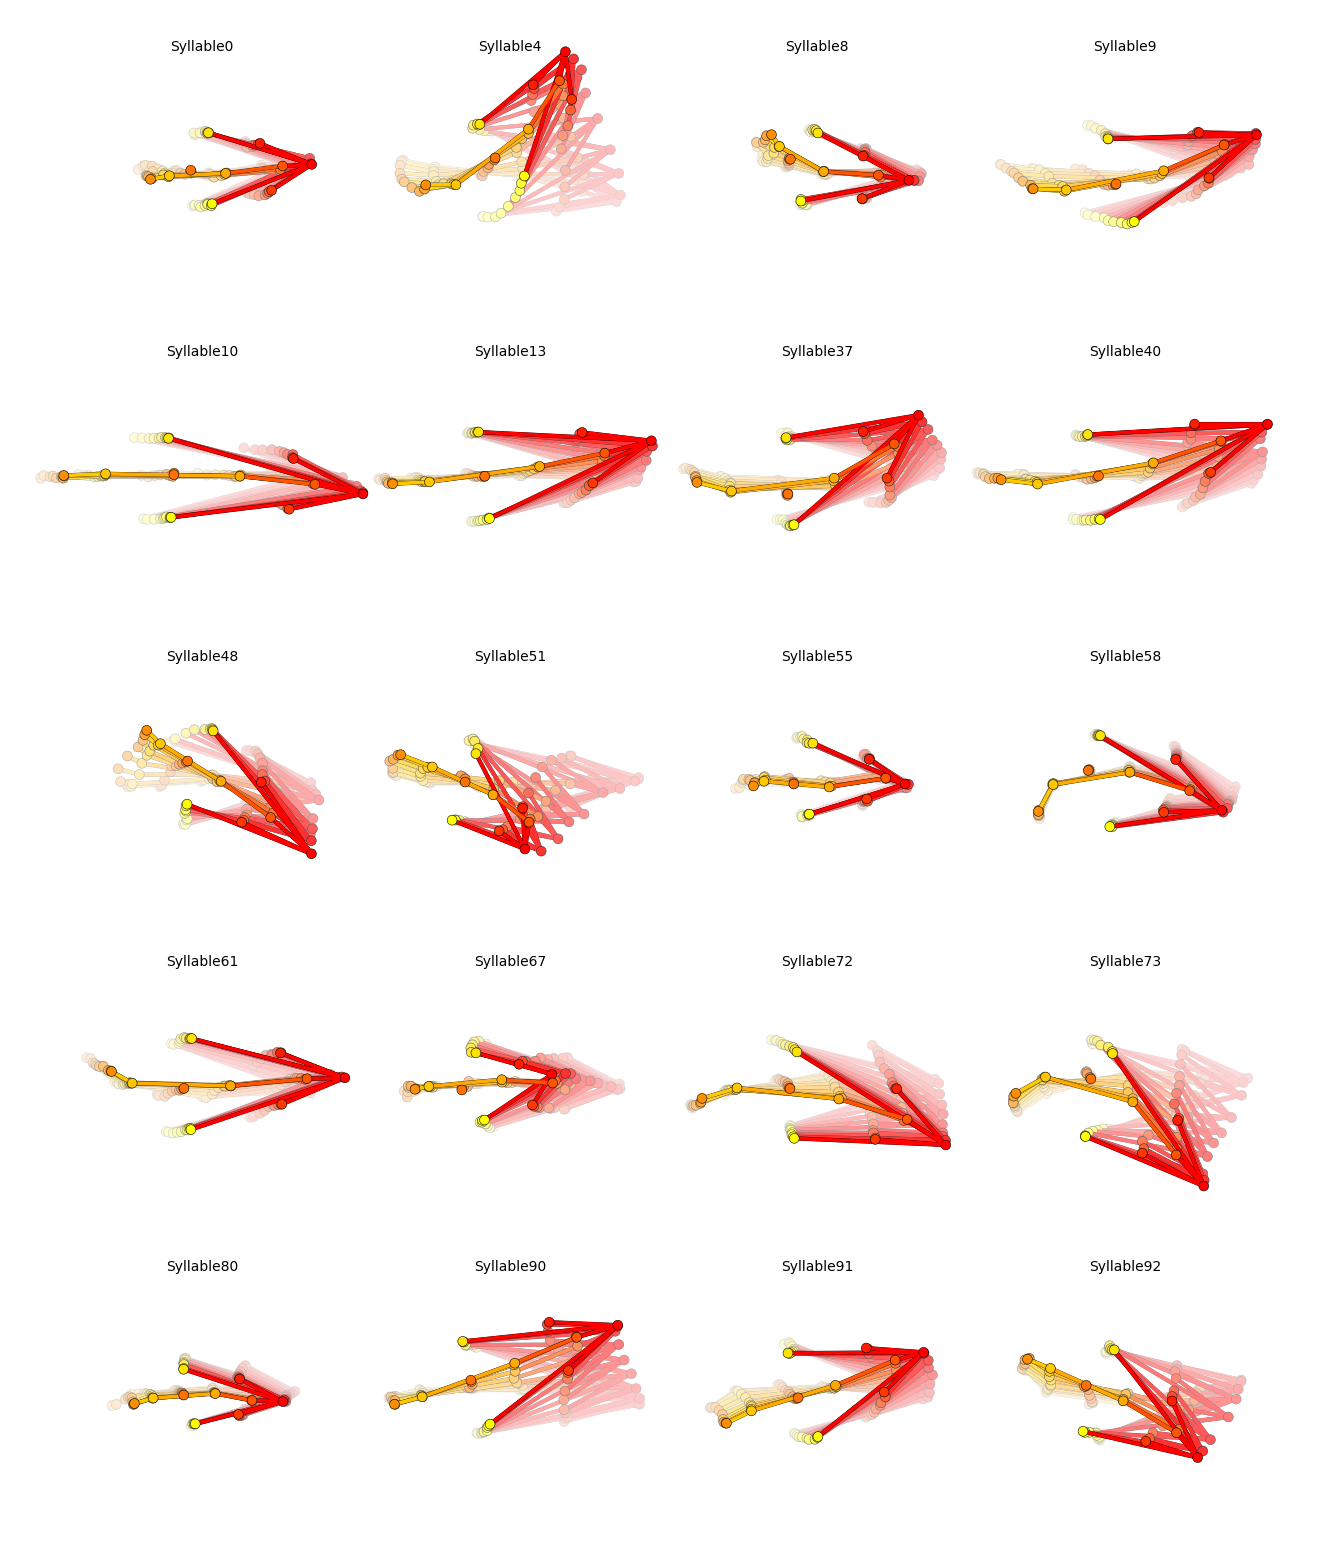

In [7]:
kpms.generate_trajectory_plots(coordinates, results, project_dir, kpmsmodel_name, min_frequency=.001, **config()) #you can take out the min_frequency argument if you want to do the default, you can change it to a lower number if you want to see more syllables

##### Generate Grid Movies:

In [8]:
kpms.generate_grid_movies(results, project_dir, kpmsmodel_name, coordinates=coordinates, min_frequency=.001,overlay_keypoints=True, **config());

Writing grid movies to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_27-13_41_35arhmm1e3\grid_movies
Using window size of 240 pixels


Generating grid movies: 100%|███████████| 20/20 [02:14<00:00,  6.73s/it]


##### Create Syllable Dendrogram:

Saving dendrogram plot to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/my_kappa_scanfull550-1000.0\similarity_dendrogram


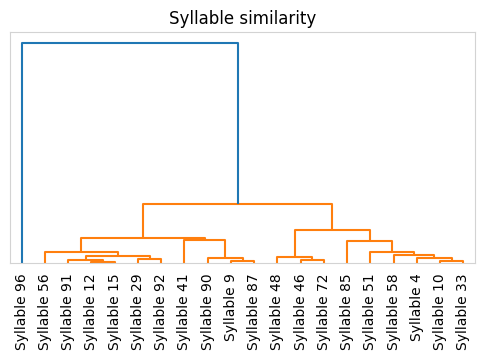

In [10]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, kpmsmodel_name, **config())

### c. .csv files for analysis

If you want to sort your videos by mutant animal and wild-type you can do it here:

In [9]:
kpms.interactive_group_setting(project_dir, kpmsmodel_name)

Row
    [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'name': 'recording name',...}, value=              ..., widths={'name': 400})
    [1] Column
        [0] Button(button_type='primary', name='Save group info')

##### to get a table that tells you **when an animal is doing a particular syllable at each frame**, you can do that here
also i'm pretty sure when onset is true, that indicates that it is the frame that a behavior starts.

In [8]:
moseq_df = kpms.compute_moseq_df(project_dir, kpmsmodel_name, smooth_heading=True) 
moseq_df

name  centroid_x  centroid_y  \
0       dL29_P0_pupretrieval_20240104_05.avi  253.904816  163.652266   
1       dL29_P0_pupretrieval_20240104_05.avi  253.344563  163.636451   
2       dL29_P0_pupretrieval_20240104_05.avi  253.401952  164.229721   
3       dL29_P0_pupretrieval_20240104_05.avi  253.790299  165.628325   
4       dL29_P0_pupretrieval_20240104_05.avi  253.585442  166.527013   
...                                      ...         ...         ...   
266167  dL44_P4_pupretrieval_20240305_01.avi  140.780796  238.927539   
266168  dL44_P4_pupretrieval_20240305_01.avi  140.140207  240.114650   
266169  dL44_P4_pupretrieval_20240305_01.avi  139.648039  240.519512   
266170  dL44_P4_pupretrieval_20240305_01.avi  139.934825  240.360047   
266171  dL44_P4_pupretrieval_20240305_01.avi  139.934181  239.262928   

         heading  angular_velocity  velocity_px_s  syllable  frame_index  \
0       1.437794          0.000000       0.000000        91            0   
1       1.437794          0.270488      16.814301        91            1   
2       1.525745          0.514034      17.881192        91            2   
3       1.525745          0.710878      43.545551        91            3   
4       1.544867          0.852125      27.652229        91            4   
...          ...               ...            ...       ...          ...   
266167  0.992598          0.138453      31.997104         9        11560   
266168  0.992598          0.126632      40.467614         9        11561   
266169  1.006545          0.104730      19.118793         9        11562   
266170  1.006545          0.074522       9.844193         9        11563   
266171  1.006545          0.038679      32.913561         9        11564   

          group  onset  
0       default   True  
1       default  False  
2       default  False  
3       default  False  
4       default  False  
...         ...    ...  
266167  default  False  
266168  default  False  
266169  default  False  
266170  default  False  
266171  default  False  

[266172 rows x 10 columns]

and now to save it as a .csv file:

In [9]:
# save moseq_df
save_dir = os.path.join(project_dir, kpmsmodel_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, 'moseq_df.csv'), index=False)
print('Saved `moseq_df` dataframe to', save_dir)

Saved `moseq_df` dataframe to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_25-09_09_03arhmm1e4


this can give you some information about the syllables i'm pretty sure:

In [10]:
stats_df = kpms.compute_stats_df(
    project_dir,
    kpmsmodel_name,
    moseq_df, 
    min_frequency=0.005,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30)                    # frame rate of the video from which keypoints were inferred

stats_df

group                                  name  syllable  heading_mean  \
0    default  dL29_P0_pupretrieval_20240104_05.avi         4      0.583654   
1    default  dL29_P0_pupretrieval_20240104_05.avi         9     -0.047251   
2    default  dL29_P0_pupretrieval_20240104_05.avi        10      0.379782   
3    default  dL29_P0_pupretrieval_20240104_05.avi        30      0.050128   
4    default  dL29_P0_pupretrieval_20240104_05.avi        48      0.076686   
..       ...                                   ...       ...           ...   
549  default  dL44_P4_pupretrieval_20240305_01.avi        86     -1.059676   
550  default  dL44_P4_pupretrieval_20240305_01.avi        90      0.561731   
551  default  dL44_P4_pupretrieval_20240305_01.avi        91     -0.092387   
552  default  dL44_P4_pupretrieval_20240305_01.avi        92      0.247402   
553  default  dL44_P4_pupretrieval_20240305_01.avi        96      1.048125   

     heading_std  heading_min  heading_max  angular_velocity_mean  \
0       1.408595    -3.124558     3.127165              -0.590992   
1       2.194835    -3.138190     3.133359               0.060120   
2       0.432583    -1.355338     1.380416               0.060109   
3       1.707828    -3.130642     3.133566              -0.146618   
4       0.997182    -3.138272     3.096172               0.199949   
..           ...          ...          ...                    ...   
549     1.872863    -3.032755     2.170543              -0.223037   
550     1.899994    -3.117173     3.129895               1.649123   
551     1.308481    -3.123177     3.135982               0.360100   
552     1.477714    -3.126614     3.027619              -0.027031   
553     0.027235     1.029391     1.087236               0.839333   

     angular_velocity_std  angular_velocity_min  angular_velocity_max  \
0               13.083079           -186.926865              5.339629   
1               14.826683           -187.749007            188.148677   
2                0.773322             -2.710926              3.442579   
3               11.762225             -5.082228            188.011974   
4                0.942557             -3.367541              5.677021   
..                    ...                   ...                   ...   
549              1.548835             -1.726810              4.417416   
550             16.550152             -4.156747            187.370538   
551              6.562644           -188.420691              4.695325   
552              6.344478           -186.040227              4.513304   
553              0.154326              0.660837              1.016040   

     velocity_px_s_mean  velocity_px_s_std  velocity_px_s_min  \
0             61.061954          64.514423           3.452585   
1             91.243301          86.771381           1.717848   
2             72.467044          77.426066           1.795862   
3             89.943590          80.119094           1.513135   
4             36.403057          31.610549           0.180739   
..                  ...                ...                ...   
549           33.262541          21.876758           3.827054   
550           57.840816          40.895724           2.536656   
551           50.275354          40.437508           0.642254   
552           81.326567          57.481314           2.083372   
553           40.207429          25.498442          20.712500   

     velocity_px_s_max  frequency  duration  
0           308.914403   0.060811  0.770370  
1           409.366421   0.175676  1.450000  
2           392.187660   0.101351  1.862222  
3           399.465829   0.128378  1.347368  
4           271.864398   0.067568  2.040000  
..                 ...        ...       ...  
549          96.236221   0.010870  0.611111  
550         184.777936   0.036232  0.843333  
551         287.422964   0.130435  1.551852  
552         305.208566   0.112319  0.948387  
553          75.110391   0.003623  0.133333  

[554 rows x 17 columns]

aaaand you can also save it:

In [11]:
# save stats_df
save_dir = os.path.join(project_dir, kpmsmodel_name)
stats_df.to_csv(os.path.join(save_dir, 'stats_df'), index=False)
print('Saved `stats_df` dataframe to', save_dir)

Saved `stats_df` dataframe to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_25-09_09_03arhmm1e4


##### Here is where you will **label your syllables**:

In [7]:
kpms.label_syllables(project_dir, kpmsmodel_name, moseq_df) 

Row
    [0] Column
        [0] Select(options=[4, 9, 10, 30, ...], value=4)
        [1] ParamFunction(function, _pane=Video, defer_load=False)
    [1] Column
        [0] Tabulator(editors={'name': None, ...}, show_index=False, titles={'syllable': 'syllable', ...}, value=    syllable l..., widths={'syllable': 100})
        [1] Column
            [0] Button(button_type='primary', name='Save syllable info')

##### Heatmap to show you **transition frequencies**

Group(s): default
Saved figure to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_25-09_09_03arhmm1e4\figures\transition_matrices.png


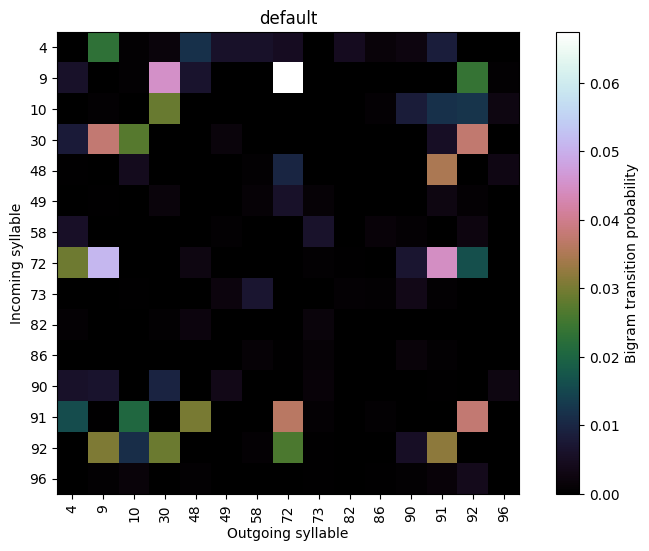

In [9]:
normalize='bigram' # normalization method ("bigram", "rows" or "columns")

trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
    project_dir, kpmsmodel_name, normalize=normalize,
    min_frequency=0.005 # minimum syllable frequency to include
)    

kpms.visualize_transition_bigram(
    project_dir, kpmsmodel_name, groups, trans_mats, syll_include, normalize=normalize, 
    show_syllable_names=False )# label syllables by index (False) or index and name (True)

##### Syllable Transition Graph

Saved figure to Y:\Karin\tutorialmaking\morekatiesvideosmodeling\keypointmoseqwork/2024_07_25-09_09_03arhmm1e4\figures\transition_graphs.png


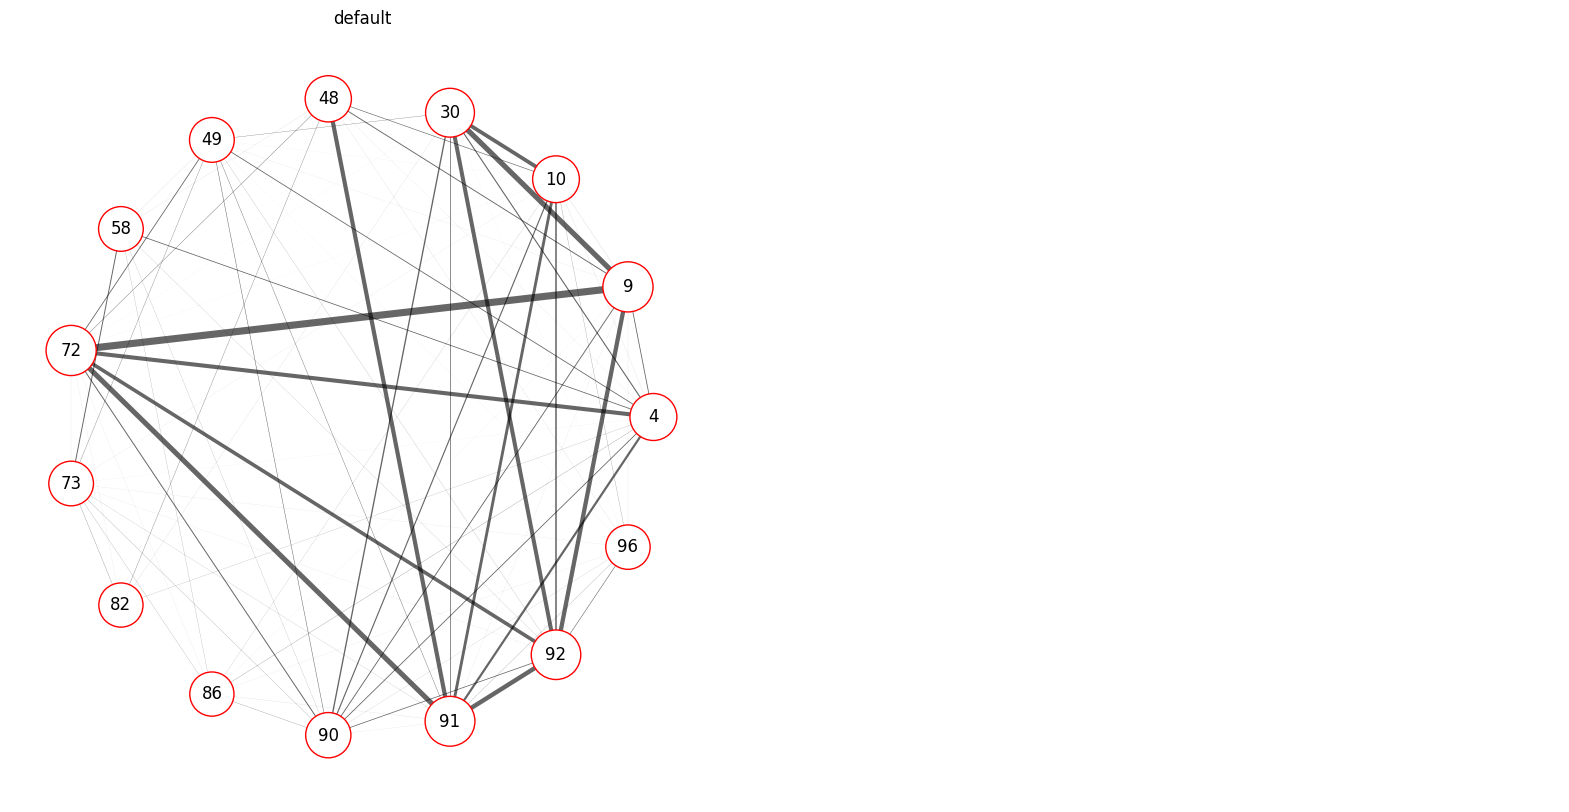

In [11]:
# Generate a transition graph for each single group

kpms.plot_transition_graph_group(
    project_dir, kpmsmodel_name, 
    groups, trans_mats, usages, syll_include, 
    layout='circular',        # transition graph layout ("circular" or "spring")
    show_syllable_names=False) # label syllables by index (False) or index and name (True)

##### Generate a difference graph

In [ ]:
# Generate a difference-graph for each pair of groups.

kpms.plot_transition_graph_difference(project_dir, kpmsmodel_name, 
                                      groups, trans_mats, usages, syll_include, 
                                      layout='circular') # transition graph layout ("circular" or "spring")